# Tutorial 1: Modeling and Basic Importance Sampling Inference

This tutorial shows how to write a probabilistic model in Gen, and how to implement a simple inference algorithm for this model.

Specifically, will implement an inference algorithm that infers the probable destination of an autonomous agent from its observed motion in a two-dimensional environment with obstacles. The algorithm will employ a generative model that includes (i) a prior distribution on the destination of the agent, and (ii) an algorithmic model for how the agent plans its movement based on its destination, (iii) a statistical model of the noise in our measurements of the agent's motion. This class of model draws inspiration from models of human cognition from the computational cognitive science literature [1]. We use this model because the results of inference are intuitive from everyday life and are straightforward to visualize.

We will break down this modeling and inference tasks into the following steps:

- **Step 1:** Implement geometric primitives for a two-dimensional scene that contains obstacles.

- **Step 2:** Implement a planning algorithm that takes the two-dimensional scene, and a starting point within the scene, and a destination point within the scene, and generates an efficient (short) path from the starting point to the destination point.

- **Step 3:** Write a generative function for the observed motion of of an autonomous agent, using the Julia code written in Steps 1 and 2.

- **Step 4:** Explore the the assumptions, or prior beliefs, that our inferences will be based on, by sampling traces of the generative function.

- **Step 5:** Use a simple importance sampling algorithm to sample probable destination points for the agent, given an example data set of observed motion.

- **Step 6:** Peek under the hood of the inference algorithm to build some intuition for how it works. 

[1] Baker, Chris L., Rebecca Saxe, and Joshua B. Tenenbaum. "Action understanding as inverse planning." Cognition 113.3 (2009): 329-349.

### The Gen package

First, we load the Gen package, which brings into scope the built-in Gen modeling languages and inference library methods. We won't use Gen itself until Step 3, but we load it here because packages are usually loaded at the beginning of a script.

In [1]:
using Gen

## Step 1: Implement geometric primitives for a two-dimensional scene with obstacles.

This step is implemented using regular Julia code.

First, we want a data type for a location in a two-dimensional plane:

In [2]:
struct Point
    x::Float64
    y::Float64
end

We will need to measure the distance between two points, so we define a method for this:

In [3]:
function dist(a::Point, b::Point)
    dx = a.x - b.x
    dy = a.y - b.y
    sqrt(dx * dx + dy * dy)
end

dist (generic function with 1 method)

We will also need to test whether two line segments intersect. The method below tests whether the line segment between the points `a1` and `a2` intersects the segment between the points `b1` and `b2`. The implementation of this primitive is based upon https://algs4.cs.princeton.edu/91primitives/. 

In [4]:
function line_segments_intersect(a1::Point, a2::Point, b1::Point, b2::Point)
    if ccw(a1, a2, b1) * ccw(a1, a2, b2) > 0
        false
    elseif ccw(b1, b2, a1) * ccw(b1, b2, a2) > 0
        false
    else
        true
    end
end

ccw(a::Point, b::Point, c::Point) = (b.x - a.x) * (c.y - a.y) - (c.x - a.x) * (b.y - a.y)

ccw (generic function with 1 method)

Next, we define a data type to represent obstacles in the scene. An obstacle will be represented by a polygon. We also define a method to test whether a given line defined by points `a1` and `a2` intersects the obstacle:

In [5]:
struct Obstacle
    vertices::Vector{Point}
end

function obstacle_intersects_line_segment(obstacle::Obstacle, a1::Point,  a2::Point)
    n = length(obstacle.vertices)
    for start_vertex_idx=1:n
        end_vertex_idx = start_vertex_idx % n + 1 # loop over to 1
        v1 = obstacle.vertices[start_vertex_idx]
        v2 = obstacle.vertices[end_vertex_idx]
        if line_segments_intersect(v1, v2, a1, a2)
            return true
        end
    end
    false
end

obstacle_intersects_line_segment (generic function with 1 method)

Now, we define a data type to represent the two-dimensional scene. The scene spans a rectangle of on the two-dimensional x-y plane, and contains a list of obstacles. Each obstacle is a polygon defined by a list of vertex points. We also define a method to compute whether a given line is obstructed by any obstacles in the scene.

In [6]:
struct Scene
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
    obstacles::Vector{Obstacle}
end

Scene(xmin, xmax, ymin, ymax) = Scene(xmin, xmax, ymin, ymax, Obstacle[])

add_obstacle!(scene, obstacle::Obstacle) = push!(scene.obstacles, obstacle)

function line_is_obstructed(scene::Scene, a1::Point, a2::Point)
    for obstacle in scene.obstacles
        if obstacle_intersects_line_segment(obstacle, a1, a2)
            return true
        end
    end
    false
end

line_is_obstructed (generic function with 1 method)

Finally, we write some methods that allow us to concisely construct walls (line-shaped obstacles that are either vertically or horizontally oriented), and square-shaped obstacles (representing trees).

In [7]:
function make_wall(vertical::Bool, start::Point, length::Float64, thickness::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = start
    dx = vertical ? thickness : length
    dy = vertical ? length : thickness
    vertices[2] = Point(start.x + dx, start.y)
    vertices[3] = Point(start.x + dx, start.y + dy) 
    vertices[4] = Point(start.x, start.y + dy)
    Obstacle(vertices)
end 

function make_tree(center::Point, size::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = Point(center.x - size/2, center.y - size/2)
    vertices[2] = Point(center.x + size/2, center.y - size/2)
    vertices[3] = Point(center.x + size/2, center.y + size/2)
    vertices[4] = Point(center.x - size/2, center.y + size/2)
    Obstacle(vertices)
end

make_tree (generic function with 1 method)

## Step 2: Implement a planning algorithm

In this step, we implement a simple planning algorithm based on the rapidly exploring random tree (RRT) algorithm [2]. The planning algorithm will take as input (i) the scene, (ii) the start point, and (iii) the destination point, and will produce a sequence of points that starts with the start point and ends with the destination point, such the line of sight between each consecutive point does not intersect any obstacles, or return failure if no path could be found.

[2] Rapidly-exploring random trees: A new tool for path planning. S. M. LaValle. TR 98-11, Computer Science Dept., Iowa State University, October 1998,

First, we define the data types for the RRT. The tree is a list of nodes, each of which stores the point (`conf`), a reference to the parent node, the vector from the parent to the node (`control`), and the total distance from the start node to this node, following the edges of the tree (`dist_from_start`).

In [8]:
struct RRTNode
    conf::Point
    parent::Union{Nothing,RRTNode}
    control::Union{Nothing,Point}
    dist_from_start::Float64
end

The RRT is a list of nodes, where the first node is the 'root' node:

In [9]:
struct RRT
    nodes::Vector{RRTNode}
end

function RRT(root_conf::Point)
    nodes = RRTNode[RRTNode(root_conf, nothing, nothing, 0.)]
    RRT(nodes)
end

add_node!(tree::RRT, node::RRTNode) = push!(tree.nodes, node)

root(tree::RRT) = tree.nodes[1]

root (generic function with 1 method)

One of the key operations used in the RRT algorithm is generating a random point in the scene:

In [10]:
function random_point_in_scene(scene::Scene)
    x = rand() * (scene.xmax - scene.xmin) + scene.xmin
    y = rand() * (scene.ymax - scene.ymin) + scene.ymin
    Point(x, y)
end

random_point_in_scene (generic function with 1 method)

Another key operation is finding the point on the tree that is closest to some other point:

In [11]:
function nearest_node_on_tree(tree::RRT, conf::Point)
    nearest::RRTNode = root(tree)
    best_dist::Float64 = dist(nearest.conf, conf)
    for node in tree.nodes
        d = dist(node.conf, conf)
        if d < best_dist
            best_dist = d 
            nearest = node
        end
    end 
    nearest
end

nearest_node_on_tree (generic function with 1 method)

Finally, we implement the RRT algorithm, which generates a RRT. It operates by randomly picking points from the scene and trying to connect them to the tree with a non-obstructed line-of-site.

In [12]:
function generate_rrt(scene::Scene, init::Point, iters::Int, dt::Float64)
    tree = RRT(init) # init is the root of tree
    for iter=1:iters
        rand_conf::Point = random_point_in_scene(scene)
        near_node::RRTNode = nearest_node_on_tree(tree, rand_conf)
        
        dist_to_target = dist(near_node.conf, rand_conf)
        diff = Point(rand_conf.x - near_node.conf.x, rand_conf.y - near_node.conf.y)
        distance_to_move = min(dt, dist_to_target)
        scale = distance_to_move / dist_to_target
        control = Point(scale * diff.x, scale * diff.y)

        # go in the direction of target_conf from start_conf 
        new_conf = Point(near_node.conf.x + control.x, near_node.conf.y + control.y)

        # test the obstacles
        failed = line_is_obstructed(scene, near_node.conf, new_conf)
        
        if !failed
            dist_from_start = near_node.dist_from_start + distance_to_move
            new_node = RRTNode(new_conf, near_node, control, dist_from_start)
            add_node!(tree, new_node)
        end
    end
    tree
end

generate_rrt (generic function with 1 method)

Given a RRT, and a destination point, we can find a path from the root of the RRT to the destination point, by finding a node on the tree that has a clear line-of-sight to the destination node, and is also as close as possible to the destination node. If there is no node on the tree with a clear line-of-sight to the destination, we return the value `nothing`:

In [13]:
function find_tree_route_to_dest(tree::RRT, dest::Point)
    best_node = tree.nodes[1]
    min_cost = Inf
    path_found = false
    for node in tree.nodes
        # check for line-of-site to the destination
        clear_path = !line_is_obstructed(scene, node.conf, dest)
        cost = node.dist_from_start + (clear_path ? dist(node.conf, dest) : Inf)
        if cost < min_cost
            path_found = true
            best_node = node
            min_cost = cost
        end
    end
    if path_found
        (best_node, min_cost)
    else
        (nothing, min_cost)
    end
end

find_tree_route_to_dest (generic function with 1 method)

Then, we obtain a sequence of points that define the path by walking back along the tree from the best tree  found node, back to the start node:

In [14]:
struct Path
    points::Vector{Point}
end

function walk_tree_to_root(node::RRTNode, start::Point, dest::Point)
    points = Point[dest]
    while node.parent != nothing
        push!(points, node.conf)
        node = node.parent
    end
    push!(points, start)
    @assert points[end] == start # the start point
    @assert points[1] == dest
    Path(reverse(points))
end

walk_tree_to_root (generic function with 1 method)

The paths along the tree that are generated by the RRT algorithm are generally not very direct. We want our agent to take fairly direct paths from its starting location to the destination. Therefore, we use the following path-refinement procedure to optimize the path points to shorten the length of the path while still avoiding obstruction by obstacles.

In [15]:
function refine_path(scene::Scene, original::Path, iters::Int, std::Float64)
    # do stochastic optimization
    new_points = copy(original.points)
    num_interior_points = length(original.points) -2
    if num_interior_points == 0
        return original
    end
    for i=1:iters
        point_idx = 2 + (i % num_interior_points)
        @assert point_idx > 1 # not start
        @assert point_idx < length(original.points) # not dest
        prev_point = new_points[point_idx-1]
        point = new_points[point_idx]
        next_point = new_points[point_idx+1]
        adjusted = Point(point.x + randn() * std, point.y + randn() * std)
        cur_dist = dist(prev_point, point) + dist(point, next_point)
        ok_backward = !line_is_obstructed(scene, prev_point, adjusted)
        ok_forward = !line_is_obstructed(scene, adjusted, next_point)
        if ok_backward && ok_forward
            new_dist = dist(prev_point, adjusted) + dist(adjusted, next_point)
            if new_dist < cur_dist
                # accept the change
                new_points[point_idx] = adjusted
            end
        end
    end
    Path(new_points)
end

refine_path (generic function with 1 method)

Finally, we combine each of the steps we just defined into a path-planning function. If a path could not be found, we return the value `nothing`. Otherwise, we return a `Path` value The path-planning function has parameters for how to grow the RRT (`rrt_iters` and `rrt_dt`) and how to perform the refinement (`refine_iters` and `refine_std`).

In [16]:
struct PlannerParams
    rrt_iters::Int
    rrt_dt::Float64 # the maximum proposal distance
    refine_iters::Int
    refine_std::Float64
end

function plan_path(start::Point, dest::Point, scene::Scene, params::PlannerParams)
    
    # Generate a rapidly exploring random tree
    tree = generate_rrt(scene, start, params.rrt_iters, params.rrt_dt)

    # Find a route from the root of the tree to a node on the tree that has a line-of-sight to the destination
    (maybe_node, min_cost) = find_tree_route_to_dest(tree, dest)
    
    if maybe_node == nothing
        
        # No route found
        nothing
    else
        
        # Route found
        node::RRTNode = something(maybe_node)
        path = walk_tree_to_root(node, start, dest)
        refine_path(scene, path, params.refine_iters, params.refine_std)
    end
end



plan_path (generic function with 1 method)

We will assume that the agent moves along its path a constant speed. The cell below defines a method that computes the locations of the agent at a set of timepoints, given the path and the speed of the agent.

In [17]:
function compute_distances_from_start(path::Path)
    distances_from_start = Vector{Float64}(undef, length(path.points))
    distances_from_start[1] = 0.0
    for i=2:length(path.points)
        distances_from_start[i] = distances_from_start[i-1] + dist(path.points[i-1], path.points[i])
    end
    return distances_from_start
end

function walk_path(path::Path, speed::Float64, dt::Float64, num_ticks::Int)
    distances_from_start = compute_distances_from_start(path)
    locations = Vector{Point}(undef, num_ticks)
    locations[1] = path.points[1]
    t = 0.
    for time_idx=1:num_ticks
        desired_distance = t * speed
        used_up_time = false
        # NOTE: can be improved (iterate through path points along with times)
        for i=2:length(path.points)
            prev = path.points[i-1]
            cur = path.points[i]
            dist_to_prev = dist(prev, cur)
            if distances_from_start[i] >= desired_distance
                # we overshot, the location is between i-1 and i
                overshoot = distances_from_start[i] - desired_distance
                @assert overshoot <= dist_to_prev
                past_prev = dist_to_prev - overshoot
                frac = past_prev / dist_to_prev
                locations[time_idx] = Point(prev.x * (1. - frac) + cur.x * frac,
                                     prev.y * (1. - frac) + cur.y * frac)
                used_up_time = true
                break
            end
        end
        if !used_up_time
            # sit at the goal indefinitely
            locations[time_idx] = path.points[end]
        end
        t += dt
    end
    locations
end

walk_path (generic function with 1 method)

## Step 3: Write a generative function for the motion of an autonomous agent

We now can write a generative function that models the behavior of an autonomous agent.

In [18]:
@gen function model(scene::Scene, dt::Float64, num_ticks::Int)

    # sample the start point of the agent from the prior
    start_x = @addr(uniform(0, 1), :start_x)
    start_y = @addr(uniform(0, 1), :start_y)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x = @addr(uniform(0, 1), :dest_x)
    dest_y = @addr(uniform(0, 1), :dest_y)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
    
    # sample the speed from the prior
    speed = @addr(uniform(0, 1), :speed)

    if maybe_path == nothing
        
        # path planning failed, assume the agent stays as the start location indefinitely
        locations = fill(start, num_ticks)
    else
        
        # path planning succeeded, move along the path at constant speed
        path = something(maybe_path)
        locations = walk_path(path, speed, dt, num_ticks)
    end

    # generate noisy measurements
    noise = 0.01
    measurements = Vector{Point}(undef, num_ticks)
    for (i, point) in enumerate(locations)
        x = @addr(normal(point.x, noise), :meas => i => :x)
        y = @addr(normal(point.y, noise), :meas => i => :y)
        measurements[i] = Point(x, y)
    end

    (start, dest, speed, noise, maybe_path, locations, measurements)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Scene, Float64, Int64], getfield(Main, Symbol("##3#5"))(), getfield(Main, Symbol("##4#6"))(), Bool[false, false, false])

We create a scene:

In [19]:
scene = Scene(0, 1, 0, 1)
add_obstacle!(scene, make_tree(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_tree(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_tree(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.20, 0.40), 0.40, wall_thickness))

8-element Array{Obstacle,1}:
 Obstacle(Point[Point(0.25, 0.15), Point(0.35, 0.15), Point(0.35, 0.25), Point(0.25, 0.25)])
 Obstacle(Point[Point(0.78, 0.75), Point(0.88, 0.75), Point(0.88, 0.85), Point(0.78, 0.85)])
 Obstacle(Point[Point(0.75, 0.35), Point(0.85, 0.35), Point(0.85, 0.45), Point(0.75, 0.45)])
 Obstacle(Point[Point(0.2, 0.4), Point(0.6, 0.4), Point(0.6, 0.42), Point(0.2, 0.42)])      
 Obstacle(Point[Point(0.6, 0.4), Point(0.62, 0.4), Point(0.62, 0.8), Point(0.6, 0.8)])      
 Obstacle(Point[Point(0.45, 0.8), Point(0.62, 0.8), Point(0.62, 0.82), Point(0.45, 0.82)])  
 Obstacle(Point[Point(0.2, 0.8), Point(0.35, 0.8), Point(0.35, 0.82), Point(0.2, 0.82)])    
 Obstacle(Point[Point(0.2, 0.4), Point(0.22, 0.4), Point(0.22, 0.8), Point(0.2, 0.8)])      

In [20]:
const dt = 0.1
const num_ticks = 10

10

In [21]:
import Random
Random.seed!(3)

# start GenViz server
using GenViz
server = VizServer(8000)
sleep(1)

In [22]:
function trace_to_dict(trace)
    args = get_args(trace)
    (scene, dt, num_ticks) = args

    retval = get_retval(trace)
    (start, dest, speed, noise, maybe_path, locations, measurements) = retval

    d = Dict()

    # scene (the obstacles)
    d["scene"] = scene

    # the path
    if maybe_path != nothing
        d["path"] = maybe_path.points
    else
        d["path"] = []
    end

    # start and destination location
    d["start"] = start
    d["dest"] = dest

    # observed points
    d["measurements"] = measurements

    d
end

trace_to_dict (generic function with 1 method)

## Step 4: Explore the assumptions of our model

In [23]:
# visualize samples from the prior
viz = Viz(server, joinpath(@__DIR__, "grid-viz/dist"), [])
openInNotebook(viz)
sleep(5)
constraints = DynamicAssignment()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1
for i=1:12
    (trace, _) = initialize(model, (scene, dt, num_ticks), constraints)
    putTrace!(viz, i, trace_to_dict(trace))
end

## Step 5: Use a simple importance sampling algorithm

In [24]:
import Random
Random.seed!(8);

In [25]:
# generate data set
constraints = DynamicAssignment()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1
constraints[:dest_x] = 0.5
constraints[:dest_y] = 0.5
(trace, _) = initialize(model, (scene, dt, num_ticks), constraints)
assmt = get_assmt(trace)
start = get_retval(trace)[1]
xs = [assmt[:meas => i => :x] for i=1:num_ticks]
ys = [assmt[:meas => i => :y] for i=1:num_ticks]
measurements = Vector{Point}(undef, num_ticks)
for (i, (x, y)) in enumerate(zip(xs, ys))
    measurements[i] = Point(x, y)
end

In [26]:
println(assmt[:speed])

0.4405486703861208


In [27]:
function do_inference(scene::Scene, dt::Float64, num_ticks::Int,
                      start::Point,
                      xs::Vector{Float64}, ys::Vector{Float64},
                      num_particles::Int)
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, (x, y)) in enumerate(zip(xs, ys))
        observations[:meas => i => :x] = x
        observations[:meas => i => :y] = y
    end
    observations = StaticAssignment(observations)
    (traces, log_weights) = importance_sampling(model, (scene, dt, num_ticks), observations, num_particles)
    idx = categorical(exp.(log_weights .- logsumexp(log_weights)))
    traces[idx]
end


do_inference (generic function with 1 method)

In [28]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)

Dict{String,Any} with 3 entries:
  "measurements" => Point[Point(0.0980245, 0.104775), Point(0.113734, 0.150773)…
  "start"        => Point(0.1, 0.1)
  "scene"        => Scene(0.0, 1.0, 0.0, 1.0, Obstacle[Obstacle(Point[Point(0.2…

In [29]:
# show results of importance sampling inference (50 particles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
traces = []
for i=1:100
    trace = do_inference(scene, dt, num_ticks, start, xs, ys, 50)
    putTrace!(viz, i, trace_to_dict(trace))
    push!(traces, trace)
end

## Heuristic feature extraction for speed proposal

In [30]:
import PyPlot

In [31]:
traces = []
for i=1:100
    (trace, _) = initialize(model, (scene, dt, num_ticks), EmptyAssignment())
    push!(traces, trace)
end

In [32]:
# for each trace, make a plot showing the true speed

In [33]:
# idea: take the pairwise distance between all observations
function consecutive_dists(measurements::Vector{Point})
    n = length(measurements)
    dists = Array{Float64}(undef, n-1)
    for i=1:n-1
        dists[i] = dist(measurements[i], measurements[i+1])
    end
    dists
end

consecutive_dists (generic function with 1 method)

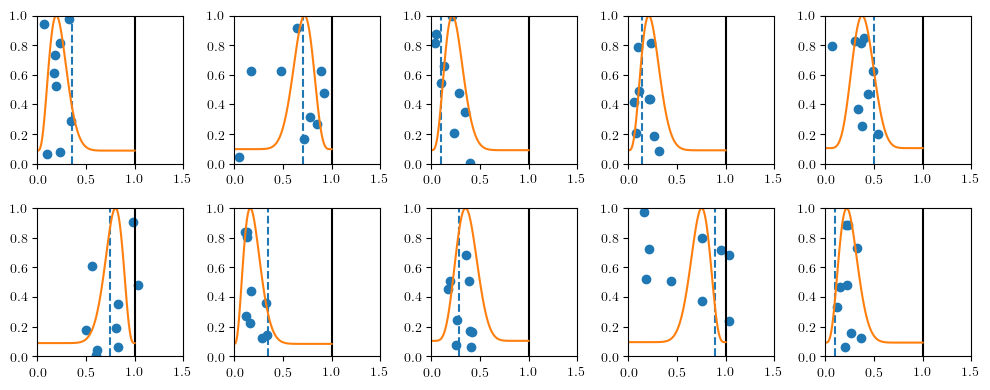

In [34]:
import Statistics
PyPlot.figure(figsize=(10, 4))
for (i, trace) in enumerate(traces[1:10])
    PyPlot.subplot(2, 5, i)
    (start, dest, speed, noise, maybe_path, locations, measurements) = get_retval(trace)
    dists = consecutive_dists(measurements)
    PyPlot.plot([speed, speed], [0, 1], "--")
    PyPlot.plot([1, 1], [0, 1], "k")
    PyPlot.scatter(dists / dt, rand(length(dists)))
    guess = Statistics.median(dists) / dt
    #PyPlot.plot([guess, guess], [0, 1], "r")
    # compute parameters of beta distribution
    N = 20
    alpha = guess * (N - 2) + 1
    beta = N - alpha
    pdfs = [exp(logpdf(beta_uniform, s, 0.7, alpha, beta)) for s in 0.0:0.01:1.0]
    PyPlot.plot(0.0:0.01:1.0, pdfs / maximum(pdfs))
    ax = PyPlot.gca()
    ax[:set_xlim](0, 1.5)
    ax[:set_ylim](0, 1)
end
PyPlot.tight_layout()

In [35]:
# visualize samples from the prior
viz = Viz(server, joinpath(@__DIR__, "grid-viz/dist"), [])
openInNotebook(viz)
sleep(5)
for (i, trace) in enumerate(traces[1:10])
    putTrace!(viz, i, trace_to_dict(trace))
end

## Step 7: Improve the algorithm

In [36]:
@gen function custom_speed_proposal(speed_guess::Float64)
    N = 20
    alpha = speed_guess * (N - 2) + 1
    beta = N - alpha
    theta = 0.9
    @addr(beta_uniform(theta, alpha, beta), :speed)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Float64], getfield(Main, Symbol("##13#15"))(), getfield(Main, Symbol("##14#16"))(), Bool[false])

In [37]:
function do_inference_custom(scene::Scene, dt::Float64, num_ticks::Int,
                             start::Point, xs::Vector{Float64}, ys::Vector{Float64},
                            num_particles::Int)
    measurements = Vector{Point}(undef, num_ticks)
    for (i, (x, y)) in enumerate(zip(xs, ys))
        measurements[i] = Point(x, y)
    end
    
    # compute a speed guess
    dists = consecutive_dists(measurements)
    speed_guess = Statistics.median(dists) / dt
    
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, (x, y)) in enumerate(zip(xs, ys))
        observations[:meas => i => :x] = x
        observations[:meas => i => :y] = y
    end
    observations = StaticAssignment(observations)
    (traces, log_weights) = importance_sampling(model, (scene, dt, num_ticks), observations,
        custom_speed_proposal, (speed_guess,), num_particles)
    idx = categorical(exp.(log_weights .- logsumexp(log_weights)))
    traces[idx]
end

do_inference_custom (generic function with 1 method)

In [38]:
# show results of importance sampling inference (50 particles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:100
    trace = do_inference_custom(scene, dt, num_ticks, start, xs, ys, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end

## Quantify improvement in performance due to custom proposal

In [ ]:
function make_location_histogram(locations::Vector{Point}, nrows::Int, ncols::Int, scene::Scene)
    counts = fill(0.01, nrows * ncols)
    xspan = scene.xmax - scene.xmin
    yspan = scene.ymax - scene.ymin
    for loc in locations
        row = Int(floor((loc.y - scene.ymin) / yspan * nrows))
        col = Int(floor((loc.x - scene.xmin) / xspan * ncols))
        @assert row < nrows
        @assert col < ncols
        counts[row * ncols + col + 1] += 1
    end
    freqs = counts ./ sum(counts)
    freqs
end

In [ ]:
default_histograms = Dict{Int,Vector{Float64}}()
default_times = Dict{Int,Vector{Float64}}()
custom_histograms = Dict{Int,Vector{Float64}}()
custom_times = Dict{Int,Vector{Float64}}()
num_particles_list = [1, 3, 10, 30, 100, 300, 1000]
nrows = 10
ncols = 10
nruns = 1000
for n in num_particles_list
    
    println("testing num_particles: $n")
    
    # run default inference
    println("default")
    traces = Vector{Any}(undef, nruns)
    times = Vector{Float64}(undef, nruns)
    for i=1:nruns
        start_time = time_ns()
        traces[i] = do_inference(scene, dt, num_ticks, start, xs, ys, n)
        times[i] = (time_ns() - start_time)/1e9
    end
    locations = [let a = get_assmt(t); Point(a[:dest_x], a[:dest_y]) end for t in traces]
    default_histograms[n] = make_location_histogram(locations, nrows, ncols, scene)
    default_times[n] = times
    
    # run custom inference
    println("custom")
    traces = Vector{Any}(undef, nruns)
    times = Vector{Float64}(undef, nruns)
    for i=1:nruns
        start_time = time_ns()
        traces[i] = do_inference_custom(scene, dt, num_ticks, start, xs, ys, n)
        times[i] = (time_ns() - start_time)/1e9
    end
    locations = [let a = get_assmt(t); Point(a[:dest_x], a[:dest_y]) end for t in traces]
    custom_histograms[n] = make_location_histogram(locations, nrows, ncols, scene)
    custom_times[n] = times
end

In [ ]:
function kl_divergence(dist1::Vector{Float64}, dist2::Vector{Float64})
    sum(dist1 .* (log.(dist1) .- log.(dist2)))
end

In [ ]:
default_kls = [kl_divergence(default_histograms[1000], default_histograms[n]) for n in num_particles_list[1:5]]
default_median_elapsed = [Statistics.median(default_times[n]) for n in num_particles_list[1:5]]
custom_kls = [kl_divergence(default_histograms[1000], custom_histograms[n]) for n in num_particles_list[1:5]]
custom_median_elapsed = [Statistics.median(custom_times[n]) for n in num_particles_list[1:5]]
PyPlot.figure(figsize=(8, 4))
PyPlot.subplot(1, 2, 1)
PyPlot.plot(num_particles_list[1:5], default_kls, label="default")
PyPlot.plot(num_particles_list[1:5], custom_kls, label="custom")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("number of particles")
PyPlot.subplot(1, 2, 2)
PyPlot.scatter(default_median_elapsed, default_kls, label="default")
PyPlot.scatter(custom_median_elapsed, custom_kls, label="custom")
PyPlot.legend()
PyPlot.ylabel("Error")
PyPlot.xlabel("Median samples per second")

## Step 8: Train a custom proposal on simulated data

In [39]:
struct PiecewiseUniform <: Distribution{Float64} end

In [40]:
const piecewise_uniform = PiecewiseUniform()

PiecewiseUniform()

In [41]:
function Gen.logpdf(::PiecewiseUniform, x::Real, bounds::AbstractVector{T}, probs::AbstractVector{U}) where {T <: Real, U <: Real}
    @assert length(bounds) == length(probs) + 1
    # bounds[1]      bounds[2]           bounds[3]      bounds[4]
    # |    probs[1]  |  probs[2]         | probs[3]     |
    if x <= bounds[1] || x >= bounds[end]
        -Inf
    end
    bin = 1
    while x > bounds[bin+1]
        bin += 1
    end
    @assert bin <= length(probs)
    log(probs[bin]) - log(bounds[bin+1] - bounds[bin])
end

function Gen.random(::PiecewiseUniform, bounds::Vector{T}, probs::Vector{U}) where {T <: Real, U <: Real}
    bin = categorical(probs)
    uniform_continuous(bounds[bin], bounds[bin+1])
end

# TODO:
#has_output_grad(::PiecewiseUniform) = false
#has_argument

In [42]:
sigmoid(x) = 1 ./ (1 .+ exp.(-x))

sigmoid (generic function with 1 method)

In [292]:
function x_neural_net2(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = sigmoid(W1 * input_layer .+ b1)
    hidden_layer_2 = sigmoid(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
end

function y_neural_net2(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real, dest_x::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last, dest_x]
    hidden_layer_1 = sigmoid(W1 * input_layer .+ b1)
    hidden_layer_2 = sigmoid(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
end

@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)
    
    
    # TODO fix the @param + @splice issue for the other Dynamic DSL GFI methods (besides propose)
    
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    #xs = [m.x for m in measurements]
    #ys = [m.y for m in measurements]
    #dxs = [xs[i+1] - xs[i] for i=1:length(xs)-1]
    #dys = [ys[i+1] - ys[i] for i=1:length(ys)-1]
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = x_neural_net2((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    dest_x = @addr(piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = y_neural_net2((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last, dest_x)
    @addr(piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    nothing
end

num_x_bins = 5
num_y_bins = 5
num_hidden_1 = 50
num_hidden_2 = 50

import Random
Random.seed!(1)

# set parameters for dest-x predictor network
init_param!(custom_dest_proposal, :x_W1, 0.001 * rand(num_hidden_1, 4))
init_param!(custom_dest_proposal, :x_b1, 0.001 * rand(num_hidden_1))
init_param!(custom_dest_proposal, :x_W2, 0.001 * rand(num_hidden_2, num_hidden_1))
init_param!(custom_dest_proposal, :x_b2, 0.001 * rand(num_hidden_2))
init_param!(custom_dest_proposal, :x_W3, 0.001 * rand(num_x_bins, num_hidden_2))
init_param!(custom_dest_proposal, :x_b3, 0.001 * rand(num_x_bins))

# set parameters for dest-y predictor network
init_param!(custom_dest_proposal, :y_W1, 0.001 * rand(num_hidden_1, 5))
init_param!(custom_dest_proposal, :y_b1, 0.001 * rand(num_hidden_1))
init_param!(custom_dest_proposal, :y_W2, 0.001 * rand(num_hidden_2, num_hidden_1))
init_param!(custom_dest_proposal, :y_b2, 0.001 * rand(num_hidden_2))
init_param!(custom_dest_proposal, :y_W3, 0.001 * rand(num_y_bins, num_hidden_2))
init_param!(custom_dest_proposal, :y_b3, 0.001 * rand(num_y_bins));

In [306]:
@gen function custom_proposal(measurements::Vector{Point}, scene::Scene, speed_guess::Float64)
    @splice(custom_dest_proposal(measurements, scene))
    @splice(custom_speed_proposal(speed_guess))
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Point,1}, Scene, Float64], getfield(Main, Symbol("##413#415"))(), getfield(Main, Symbol("##414#416"))(), Bool[false, false, false])

In [308]:
# visualize the proposal density for a given data set.. (run logpdf on custom_dest_proposal)
function make_proposal_tiles(measurements::Vector{Point}, scene::Scene, num_x_bins::Int, num_y_bins::Int)
    dest_proposal_tiles = [] # each tile contains a {x, y, w, h, alpha}
    xspan = scene.xmax - scene.xmin
    yspan = scene.ymax - scene.ymin
    w = xspan / num_x_bins
    h = yspan / num_y_bins
    for col=1:num_x_bins
        for row=1:num_y_bins
            x = scene.xmin + (col - 1) * w
            y = scene.ymin + (row - 1) * h
            assmt = DynamicAssignment()
            assmt[:dest_x] = x + (w/2)
            assmt[:dest_y] = y + (h/2)
            (weight, _) = assess(custom_dest_proposal, (measurements, scene), assmt)
            tile = Dict("x" => x, "y" => y, "w" => w, "h" => h, "density" => exp(weight))
            push!(dest_proposal_tiles, tile)
        end
    end
    max_density = maximum([tile["density"] for tile in dest_proposal_tiles])
    for tile in dest_proposal_tiles
        tile["density"] /= max_density
    end
    dest_proposal_tiles
end

make_proposal_tiles (generic function with 2 methods)

In [295]:
tiles = make_proposal_tiles(measurements, scene, (0.5, 0.5), 5, 5)

25-element Array{Any,1}:
 Dict("w"=>0.2,"density"=>0.996471,"x"=>0.0,"h"=>0.2,"y"=>0.0)
 Dict("w"=>0.2,"density"=>0.997766,"x"=>0.0,"h"=>0.2,"y"=>0.2)
 Dict("w"=>0.2,"density"=>0.996874,"x"=>0.0,"h"=>0.2,"y"=>0.4)
 Dict("w"=>0.2,"density"=>0.99861,"x"=>0.0,"h"=>0.2,"y"=>0.6) 
 Dict("w"=>0.2,"density"=>0.996122,"x"=>0.0,"h"=>0.2,"y"=>0.8)
 Dict("w"=>0.2,"density"=>0.994613,"x"=>0.2,"h"=>0.2,"y"=>0.0)
 Dict("w"=>0.2,"density"=>0.995905,"x"=>0.2,"h"=>0.2,"y"=>0.2)
 Dict("w"=>0.2,"density"=>0.995014,"x"=>0.2,"h"=>0.2,"y"=>0.4)
 Dict("w"=>0.2,"density"=>0.996748,"x"=>0.2,"h"=>0.2,"y"=>0.6)
 Dict("w"=>0.2,"density"=>0.994265,"x"=>0.2,"h"=>0.2,"y"=>0.8)
 Dict("w"=>0.2,"density"=>0.997793,"x"=>0.4,"h"=>0.2,"y"=>0.0)
 Dict("w"=>0.2,"density"=>0.999089,"x"=>0.4,"h"=>0.2,"y"=>0.2)
 Dict("w"=>0.2,"density"=>0.998196,"x"=>0.4,"h"=>0.2,"y"=>0.4)
 Dict("w"=>0.2,"density"=>0.999934,"x"=>0.4,"h"=>0.2,"y"=>0.6)
 Dict("w"=>0.2,"density"=>0.997444,"x"=>0.4,"h"=>0.2,"y"=>0.8)
 Dict("w"=>0.2,"density"=>0.99

In [304]:
function do_inference_custom2(scene::Scene, dt::Float64, num_ticks::Int,
                             start::Point, xs::Vector{Float64}, ys::Vector{Float64},
                             num_particles::Int)
    
    measurements = Vector{Point}(undef, num_ticks)
    for (i, (x, y)) in enumerate(zip(xs, ys))
        measurements[i] = Point(x, y)
    end
    
    # compute a speed guess
    dists = consecutive_dists(measurements)
    speed_guess = Statistics.median(dists) / dt
    
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, (x, y)) in enumerate(zip(xs, ys))
        observations[:meas => i => :x] = x
        observations[:meas => i => :y] = y
    end
    observations = StaticAssignment(observations)
    (traces, log_weights) = importance_sampling(model, (scene, dt, num_ticks), observations,
        custom_proposal, (measurements, scene, speed_guess), num_particles)
    idx = categorical(exp.(log_weights .- logsumexp(log_weights)))
    traces[idx]
end

do_inference_custom2 (generic function with 1 method)

In [297]:
# show proposal density
info = Dict("measurements" => measurements, "scene" => scene, "start" => start, "tiles" => tiles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:100
    trace = do_inference_custom2(scene, dt, num_ticks, start, xs, ys, 1)
    putTrace!(viz, i, trace_to_dict(trace))
end

In [298]:
# ADAM

mutable struct ADAMOptimizerState
    m::Dict{Symbol,Any}
    v::Dict{Symbol,Any}
    params::Dict{Symbol,Any} # gets mutated
    t::Float64
end

function ADAMOptimizerState(params::Dict{Symbol,Any})
    m = Dict{Symbol,Any}()
    v = Dict{Symbol,Any}()
    for (param_name, param_value) in params
        m[param_name] = zero(param_value)
        v[param_name] = zero(param_value)
    end
    ADAMOptimizerState(m, v, params, 1.)
end

function update_params!(state::ADAMOptimizerState, param_grads::Dict{Symbol,Any})
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    alpha = 0.00001
    for param_name in keys(state.params)
        grad = -param_grads[param_name]
        m_new = beta1 .* state.m[param_name] + (1-beta1).*grad
        v_new = beta2 .* state.v[param_name] + (1-beta2).*(grad.^2)
        m_hat = m_new ./ (1. - beta1.^state.t)
        v_hat = v_new ./ (1. - beta2.^state.t)
        current = state.params[param_name]
        new = current .- alpha * m_hat ./ (sqrt.(v_hat) .+ eps)
        state.params[param_name] = new
        state.m[param_name] = m_new
        state.v[param_name] = v_new
    end
    state.t += 1
end

update_params! (generic function with 3 methods)

In [299]:
# regular SGD

mutable struct SGDState2
    params::Dict{Symbol,Any}
    t::Int
    init_step_size::Float64
    beta::Float64
end

SGDState2(params, init_step_size, beta) = SGDState2(params, 1, init_step_size, beta)

function update_params!(state::SGDState2, param_grads::Dict{Symbol,Any})
    step_size = state.init_step_size * (state.beta + 1) / (state.beta + state.t)
    for param_name in keys(state.params)
        state.params[param_name] += param_grads[param_name] * step_size
    end
    state.t += 1
end

update_params! (generic function with 3 methods)

In [300]:
# train the proposal on simulated data..

function translator(assmt, retval)
    measurements = Vector{Point}(undef, num_ticks)
    for i=1:num_ticks
        x = assmt[:meas => i => :x]
        y = assmt[:meas => i => :y]
        measurements[i] = Point(x, y)
    end
    inputs = (measurements, scene)
    constraints = DynamicAssignment()
    constraints[:dest_x] = assmt[:dest_x]
    constraints[:dest_y] = assmt[:dest_y]
    (inputs, constraints)
end

params = custom_dest_proposal.params # TODO this is not part of the GFI

#adam_state = ADAMOptimizerState(params)
state = SGDState2(params, 0.1, 1000)

function minibatch_callback(epoch, minibatch, avg_score, verbose)
    param_names = [:x_W1, :x_b1, :x_W2, :x_b2, :x_W3, :x_b3, :y_W1, :y_b1, :y_W2, :y_b2, :y_W3, :y_b3]
    
    # get value of gradient accumulator
    param_grads = Dict{Symbol,Any}()
    for param_name in param_names
        param_grads[param_name] = get_param_grad(custom_dest_proposal, param_name)
    end
    
    # do parameter update
    update_params!(state, param_grads)
    
    # reset gradient accumulators
    for param_name in param_names
        zero_param_grad!(custom_dest_proposal, param_name)
    end
end

function epoch_callback(epoch, verbose)
    
    num_test = 10000
    avg_score = 0.
    for i=1:num_test
        (assmt, _, retval) = propose(model, (scene, dt, num_ticks))
        (inputs, constraints) = translator(assmt, retval)
        (incr, _) = assess(custom_dest_proposal, inputs, constraints)
        avg_score += incr
    end
    avg_score /= num_test
    
    println("epoch $epoch, avg_score: $avg_score, step_size: $(state.init_step_size * (state.beta + 1) / (state.beta + state.t))")
end

epoch_callback (generic function with 1 method)

In [301]:
function planner_success_filter(assmt, retval)
    (start, dest, speed, noise, maybe_path, locations, measurements) = retval
    maybe_path != nothing
end

planner_success_filter (generic function with 1 method)

In [276]:
# measure the objective function for the uniform proposal
@gen function uniform_dest_proposal(measurements, scene)
    @addr(uniform_continuous(scene.xmin, scene.xmax), :dest_x)
    @addr(uniform_continuous(scene.ymin, scene.ymax), :dest_y)
end

num_test = 10000
avg_score = 0.
i = 1
attempted = 0
while i <= num_test
    (assmt, _, retval) = propose(model, (scene, dt, num_ticks))
    if planner_success_filter(assmt, retval)
        (inputs, constraints) = translator(assmt, retval)
        (incr, _) = assess(uniform_dest_proposal, inputs, constraints)
        avg_score += incr
        i += 1
    end
    attempted += 1
end
avg_score /= num_test
println("avg score for uniform dest proposal: $avg_score")
println("acceptance rate: $(num_test/attempted)")

avg score for uniform dest proposal: 0.0
acceptance rate: 0.8796622097114708


In [302]:
conf = SGDTrainConf(100, 10000, 100, 100, translator, minibatch_callback, epoch_callback)
sgd_train(model, (scene, dt, num_ticks), custom_dest_proposal, conf;
    filter=planner_success_filter, verbose=false)

epoch 1, avg_score: -0.09427653185730694, step_size: 0.09091734786557676
epoch 2, avg_score: -0.3135637265303137, step_size: 0.08334721065778519
epoch 3, avg_score: -0.06764326005623683, step_size: 0.07694081475787856
epoch 4, avg_score: -0.037137792731419816, step_size: 0.07144896502498216
epoch 5, avg_score: -0.05748195711389567, step_size: 0.06668887408394404
epoch 6, avg_score: -0.07008139369792712, step_size: 0.06252342286071207
epoch 7, avg_score: -0.06902446805353663, step_size: 0.05884773662551441
epoch 8, avg_score: 0.030653759349686907, step_size: 0.055580233203775684
epoch 9, avg_score: 0.04783315295925513, step_size: 0.05265649658074698
epoch 10, avg_score: 0.11463769905931004, step_size: 0.05002498750624688
epoch 11, avg_score: 0.08073539238050115, step_size: 0.04764397905759163
epoch 12, avg_score: 0.06218809415918306, step_size: 0.04547932757837347
epoch 13, avg_score: 0.11893841768782187, step_size: 0.04350282485875707
epoch 14, avg_score: 0.1186501192984208, step_size:

InterruptException: InterruptException:

In [309]:
# show proposal density
tiles = make_proposal_tiles(measurements, scene, 5, 5)
info = Dict("measurements" => measurements, "scene" => scene, "start" => start, "tiles" => tiles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:100
    trace = do_inference_custom2(scene, dt, num_ticks, start, xs, ys, 1)
    putTrace!(viz, i, trace_to_dict(trace))
end

In [316]:
import Random
Random.seed!(14);

# generate data set
constraints = DynamicAssignment()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1
constraints[:dest_x] = 0.5
constraints[:dest_y] = 0.5
(trace, _) = initialize(model, (scene, dt, num_ticks), constraints)
assmt = get_assmt(trace)
start = get_retval(trace)[1]
xs = [assmt[:meas => i => :x] for i=1:num_ticks]
ys = [assmt[:meas => i => :y] for i=1:num_ticks]
measurements = Vector{Point}(undef, num_ticks)
for (i, (x, y)) in enumerate(zip(xs, ys))
    measurements[i] = Point(x, y)
end
# show proposal density
tiles = make_proposal_tiles(measurements, scene, 5, 5)
info = Dict("measurements" => measurements, "scene" => scene, "start" => start, "tiles" => tiles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:100
    trace = do_inference_custom2(scene, dt, num_ticks, start, xs, ys, 1)
    putTrace!(viz, i, trace_to_dict(trace))
end

In [ ]:
# show results of importance sampling inference (1000 particles)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:100
    trace = do_inference_custom2(scene, dt, num_ticks, start, xs, ys, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end